TensorFlow Recommenders (TFRS) is a library for building recommender system models.

It helps with the full workflow of building a recommender system: data preparation, model formulation, training, evaluation, and deployment.

It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

TFRS makes it possible to:
Build and evaluate flexible recommendation retrieval models.
Freely incorporate item, user, and context information into recommendation models.
Train multi-task models that jointly optimize multiple recommendation objectives.
TFRS is open source and available on Github.

In [73]:
# Importing necessary libraries
import os               # Operating system module for interacting with the operating system
import tempfile         # Module to create temporary files and directories

import matplotlib.pyplot as plt  # Matplotlib library for creating visualizations

import numpy as np       # NumPy library for numerical operations
import tensorflow as tf  # TensorFlow, a machine learning framework

# TensorFlow Datasets (tfds) for easy access to various datasets
import tensorflow_datasets as tfds

# TensorFlow Recommenders (tfrs) for building recommendation models
import tensorflow_recommenders as tfrs


In [74]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

In [75]:
for x in ratings.take(1).as_numpy_iterator():
    print(x)

{'bucketized_user_age': 45.0, 'movie_genres': array([7], dtype=int64), 'movie_id': b'357', 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)", 'raw_user_age': 46.0, 'timestamp': 879024327, 'user_gender': True, 'user_id': b'138', 'user_occupation_label': 4, 'user_occupation_text': b'doctor', 'user_rating': 4.0, 'user_zip_code': b'53211'}


In [76]:
for x in movies.take(1).as_numpy_iterator():
    print(x)

{'movie_genres': array([4], dtype=int64), 'movie_id': b'1681', 'movie_title': b'You So Crazy (1994)'}


In [77]:
# Mapping the 'ratings' dataset to extract specific features of interest
ratings = ratings.map(lambda x: {
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
    "user_rating": x["user_rating"],
    "user_occupation_label": x["user_occupation_label"],
    "raw_user_age": x["raw_user_age"],
    # Commented out for now: "movie_genres": x["movie_genres"],
    "user_gender": x["user_gender"],
    "user_occupation_text": x["user_occupation_text"],
    "movie_title": x["movie_title"],
})

# Mapping the 'movies' dataset to extract only the 'movie_title' information
movies = movies.map(lambda x: x["movie_title"])

We also do some housekeeping to prepare feature vocabularies.

In [78]:
max_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(
    tf.cast(0, tf.int64), tf.maximum).numpy().max()
min_timestamp = ratings.map(lambda x: x["timestamp"]).reduce(
    np.int64(1e9), tf.minimum).numpy().min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000)

In [79]:
unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))

unique_user_ids = np.unique(np.concatenate(list(ratings.map(lambda x:
                                                            x["user_id"]).batch(128))))

In [80]:
unique_movie_titles

array([b"'Til There Was You (1997)", b'1-900 (1994)',
       b'101 Dalmatians (1996)', ..., b'Zeus and Roxanne (1997)',
       b'unknown', b'\xc3\x81 k\xc3\xb6ldum klaka (Cold Fever) (1994)'],
      dtype=object)

## SPLITTING DATA INTO TRAIN AND TEST SETS

In [81]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [82]:
len(cached_train), len(cached_test)

(40, 5)

# MODELS AND METRICS 

Real-world recommender systems are often composed of two stages:

The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.


A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
A candidate model computing the candidate representation (an equally-sized vector) using the candidate features
The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.


Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

The query tower

The first step is to decide on the dimensionality of the query and candidate representations:


embedding_dimension = 32
Higher values will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting.

The second is to define the model itself. Here, we're going to use Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an Embedding layer. Note that we use the list of unique user ids we computed earlier as a vocabulary:

In [83]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.user_id_lookup = tf.keras.layers.StringLookup()
        self.user_id_lookup.adapt(ratings.map(lambda x: x["user_id"]))

        self.user_embedding = tf.keras.Sequential([
            self.user_id_lookup,
            tf.keras.layers.Embedding(self.user_id_lookup.vocabulary_size(), 32),
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 2, 32)
        ])
        self.normalized_timestamp = tf.keras.layers.Normalization(
            axis=None
        )
        self.normalized_timestamp.adapt(
            ratings.map(lambda x: x["timestamp"]).batch(128))

        self.user_occupation_text_vectorizer = tf.keras.layers.TextVectorization()
        self.user_occupation_text_vectorizer.adapt(
            ratings.map(lambda x: x["user_occupation_text"]))
        self.user_occupation_text_embedding = tf.keras.Sequential([
            self.user_occupation_text_vectorizer,
            tf.keras.layers.Embedding(
                self.user_occupation_text_vectorizer.vocabulary_size() + 2, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        res = tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
            tf.reshape(inputs["user_rating"], (-1, 1)),
            tf.reshape(tf.cast(inputs["user_occupation_label"], tf.float32), (-1, 1)),
            tf.reshape(tf.cast(inputs["raw_user_age"], tf.float32), (-1, 1)),
            #tf.reshape(tf.cast(inputs["movie_genres"], tf.float32), (-1, 1)),
            tf.reshape(tf.cast(inputs["user_gender"], tf.float32), (-1, 1)),
            self.user_occupation_text_embedding(inputs["user_occupation_text"]),
        ], axis=1)
        print("USER MODEL OUTPUT SHAPE: ", res.shape)
        return res

In [84]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes):
        """Model for encoding user queries.
    
        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        print("CREATING USER MODEL...")
        self.embedding_model = UserModel()
        print("USER MODEL CREATED...")

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

The candidate tower

We can do the same with the candidate tower.

In [85]:
class MovieModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        self.title_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])

        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=max_tokens)

        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

In [101]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""

    def __init__(self, layer_sizes):
        """Model for encoding movies.
    
        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()

        self.embedding_model = MovieModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

A multi-task model
There are two critical parts to multi-task recommenders:

They optimize for two or more objectives, and so have two or more losses.
They share variables between the tasks, allowing for transfer learning.
    We will have two tasks: one that predicts ratings, and one that predicts movie watches.

In [102]:
class MovielensModel(tfrs.models.Model):

    def __init__(self, layer_sizes):
        super().__init__()

        print("CREATING QUERY MODEL...")
        self.query_model = QueryModel(layer_sizes)
        print("CREATING CANDIDATE MODEL...")
        self.candidate_model = CandidateModel(layer_sizes)

        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])
        #         Metrics
        # In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.
        # 
        # To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.


        #         Loss
        # The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.
        # 
        # In this instance, we'll make use of the Retrieval task object: a convenience wrapper that bundles together the loss function and metric computation:
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model),
            ),
        )
        # The tasks.
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(self.candidate_model)
            )
        )

        # The loss weights.
        self.rating_weight = 0.5
        self.retrieval_weight = 0.5

    def compute_loss(self, features, training=False):
        # query_embeddings = self.query_model({
        #     "user_id": features["user_id"],
        #     "timestamp": features["timestamp"],
        #     "user_rating": features["user_rating"],
        #     "user_occupation_label": features["user_occupation_label"],
        #     "raw_user_age": features["raw_user_age"],
        #     #"movie_genres": features["movie_genres"],
        #     "user_gender": features["user_gender"],
        #     "user_occupation_text": features["user_occupation_text"],
        # })
        # movie_embeddings = self.candidate_model({
        #     "movie_title": features["movie_title"],
        #     #"movie_genres": features["movie_genres"],
        # })
        # return self.task(query_embeddings, movie_embeddings, compute_metrics=not training)

        ratings_popped = features.get("user_rating")

        user_embeddings, movie_emb, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings_popped,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, movie_emb)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

    def call(self, features):
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "timestamp": features["timestamp"],
            "user_rating": features["user_rating"],
            "user_occupation_label": features["user_occupation_label"],
            "raw_user_age": features["raw_user_age"],
            #"movie_genres": features["movie_genres"],
            "user_gender": features["user_gender"],
            "user_occupation_text": features["user_occupation_text"],
        })
        movie_embeddings = self.candidate_model(features["movie_title"])

        ratings_pred = self.rating_model(tf.concat([query_embeddings, movie_embeddings], axis=1))

        return query_embeddings, movie_embeddings, ratings_pred

### Shallow model


In [122]:
num_epochs = 40

In [123]:
model = MovielensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

CREATING QUERY MODEL...
CREATING USER MODEL...
USER MODEL CREATED...
CREATING CANDIDATE MODEL...


In [124]:
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

Epoch 1/40
USER MODEL OUTPUT SHAPE:  (None, 101)
USER MODEL OUTPUT SHAPE:  (None, 101)
40/40 [==============================] - 12s 202ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0163 - factorized_top_k/top_5_categorical_accuracy: 0.0245 - factorized_top_k/top_10_categorical_accuracy: 0.0312 - factorized_top_k/top_50_categorical_accuracy: 0.0659 - factorized_top_k/top_100_categorical_accuracy: 0.1063 - root_mean_squared_error: 6.4718 - loss: 12023.9969 - regularization_loss: 0.0000e+00 - total_loss: 12023.9969
Epoch 2/40
40/40 [==============================] - 9s 201ms/step - factorized_top_k/top_1_categorical_accuracy: 3.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0037 - factorized_top_k/top_10_categorical_accuracy: 0.0091 - factorized_top_k/top_50_categorical_accuracy: 0.0641 - factorized_top_k/top_100_categorical_accuracy: 0.1369 - root_mean_squared_error: 0.6028 - loss: 7220.9261 - regularization_loss: 0.0000e+00 - total_loss: 7220.9261
Epoch 3/40
40/40 

In [125]:
# save model
model.save_weights('WEIGHTS_2l', save_format='tf')

loaded_model = MovielensModel([32])
loaded_model.load_weights('WEIGHTS_2l')

CREATING QUERY MODEL...
CREATING USER MODEL...
USER MODEL CREATED...
CREATING CANDIDATE MODEL...


In [126]:
# take first user from train set
user = None
for r in ratings.take(1).as_numpy_iterator():
    user = r
    break
print(user)

{'user_id': b'138', 'timestamp': 879024327, 'user_rating': 4.0, 'user_occupation_label': 4, 'raw_user_age': 46.0, 'user_gender': True, 'user_occupation_text': b'doctor', 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)"}


In [127]:
# make recommendations for this user
input_tensors = {
    'user_id': tf.constant(['138']),
    'timestamp': tf.constant([879024327]),
    'user_rating': tf.constant([4.0]),
    'user_occupation_label': tf.constant([4]),
    'raw_user_age': tf.constant([46.0]),
    'user_gender': tf.constant([True]),
    'user_occupation_text': tf.constant(['doctor']),
    'movie_title': tf.constant(["One Flew Over the Cuckoo's Nest (1975)"])
}

tr_emb_user, tr_emb_movie, tr_rating_pred = loaded_model(input_tensors)

USER MODEL OUTPUT SHAPE:  (1, 101)


In [128]:
tr_rating_pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.5365236]], dtype=float32)>

In [129]:
brute_force = tfrs.layers.factorized_top_k.BruteForce(loaded_model.query_model)
brute_force.index_from_dataset(
    movies.batch(128).map(lambda title: (title, loaded_model.candidate_model(title))))

In [130]:
# Get predictions for user 42.
_, titles = brute_force(input_tensors, k=10)

USER MODEL OUTPUT SHAPE:  (1, 101)


In [131]:
print(f"Top recommendations: {titles[0]}")

Top recommendations: [b'Local Hero (1983)' b'Apartment, The (1960)'
 b'Treasure of the Sierra Madre, The (1948)' b'Secrets & Lies (1996)'
 b'Duck Soup (1933)' b'Annie Hall (1977)' b'Big Night (1996)'
 b'Third Man, The (1949)' b'Old Man and the Sea, The (1958)'
 b'Eat Drink Man Woman (1994)']


In [132]:
accuracy = one_layer_history.history
print(accuracy)

{'factorized_top_k/top_1_categorical_accuracy': [0.01626249961555004, 0.00032500000088475645, 0.00047500000800937414, 0.0006125000072643161, 0.0009749999735504389, 0.001362500013783574, 0.001537499949336052, 0.00215000007301569, 0.0019000000320374966, 0.0022499999031424522, 0.0019249999895691872, 0.0024500000290572643, 0.002162500051781535, 0.002537500113248825, 0.0022499999031424522, 0.0024500000290572643, 0.002474999986588955, 0.002337499987334013, 0.0023250000085681677, 0.002762499963864684, 0.002537500113248825, 0.0024874999653548002, 0.0024874999653548002, 0.0025875000283122063, 0.0024125000927597284, 0.0025500000920146704, 0.002725000027567148, 0.002762499963864684, 0.002624999964609742, 0.0027000000700354576, 0.002850000048056245, 0.002575000049546361, 0.002675000112503767, 0.0028375000692903996, 0.0028375000692903996, 0.002675000112503767, 0.0026499999221414328, 0.0023125000298023224, 0.0025625000707805157, 0.003000000026077032], 'factorized_top_k/top_5_categorical_accuracy': [

In [113]:
model = MovielensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

CREATING QUERY MODEL...
CREATING USER MODEL...
USER MODEL CREATED...
CREATING CANDIDATE MODEL...
Epoch 1/40
USER MODEL OUTPUT SHAPE:  (None, 101)
USER MODEL OUTPUT SHAPE:  (None, 101)
40/40 [==============================] - 14s 243ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0390 - factorized_top_k/top_5_categorical_accuracy: 0.0419 - factorized_top_k/top_10_categorical_accuracy: 0.0433 - factorized_top_k/top_50_categorical_accuracy: 0.0593 - factorized_top_k/top_100_categorical_accuracy: 0.0835 - root_mean_squared_error: 19.5507 - loss: 14127.0737 - regularization_loss: 0.0000e+00 - total_loss: 14127.0737
Epoch 2/40
40/40 [==============================] - 11s 247ms/step - factorized_top_k/top_1_categorical_accuracy: 3.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0016 - factorized_top_k/top_10_categorical_accuracy: 0.0030 - factorized_top_k/top_50_categorical_accuracy: 0.0163 - factorized_top_k/top_100_categorical_accuracy: 0.0390 - root_mean_squared_error: 1

In [114]:
accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:f}.")

Top-100 accuracy: 0.207800.


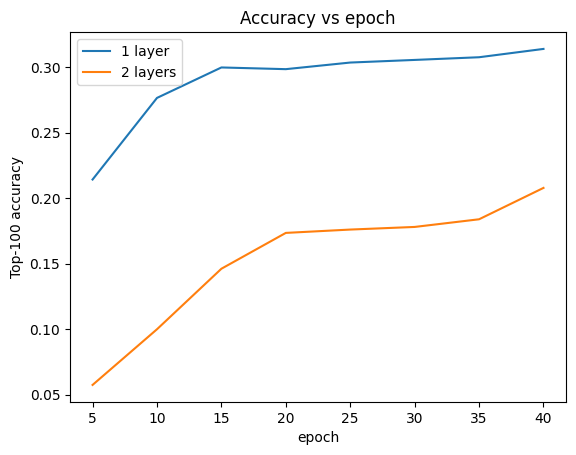

In [115]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1) * 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

In [116]:
model = MovielensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")


CREATING QUERY MODEL...
CREATING USER MODEL...
USER MODEL CREATED...
CREATING CANDIDATE MODEL...
Epoch 1/40
USER MODEL OUTPUT SHAPE:  (None, 101)
USER MODEL OUTPUT SHAPE:  (None, 101)
40/40 [==============================] - 15s 252ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0725 - factorized_top_k/top_5_categorical_accuracy: 0.0845 - factorized_top_k/top_10_categorical_accuracy: 0.0950 - factorized_top_k/top_50_categorical_accuracy: 0.1329 - factorized_top_k/top_100_categorical_accuracy: 0.1583 - root_mean_squared_error: 24.4476 - loss: 9540.4812 - regularization_loss: 0.0000e+00 - total_loss: 9540.4812
Epoch 2/40
40/40 [==============================] - 11s 250ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0058 - factorized_top_k/top_10_categorical_accuracy: 0.0103 - factorized_top_k/top_50_categorical_accuracy: 0.0404 - factorized_top_k/top_100_categorical_accuracy: 0.0761 - root_mean_squared_error: 1.1899 

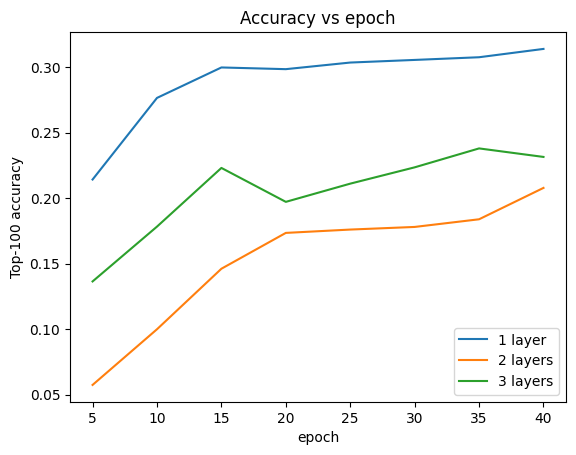

In [117]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

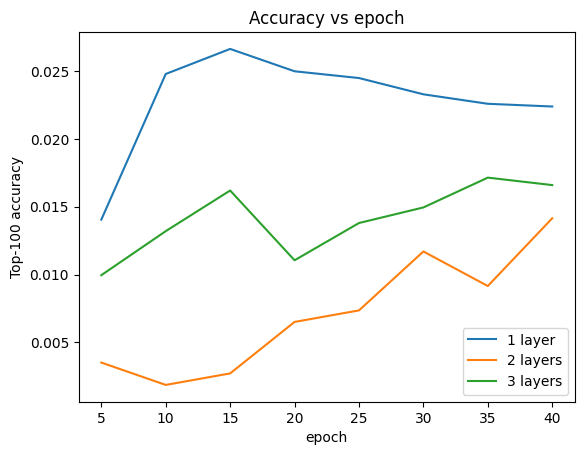

In [119]:
# make same plot for other metrics
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

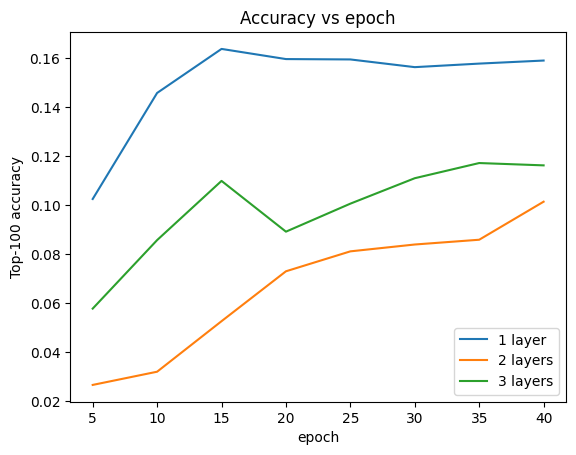

In [120]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()

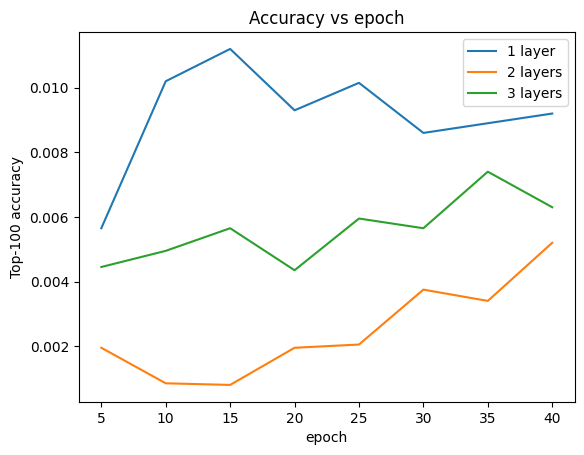

In [121]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy")
plt.legend()